# Predicting Catalog Demand



## Business and Data Understanding

A company manufactures and sells high-end home goods. Last year it sent out its first print catalogue and is preparing to send out the new catalog for the year. From the mailing list the company has 250 new customers they would like to send the catalogue to. The company wants to determine how much profit can be expected from sending the catalogue to these customers. Management has set a profit threshold of $10,000. If the expected profits meet or exceed this threshold, then the catalogue will be sent.

Key Decisions:

1. **What decisions needs to be made?**

    Whether or not the print catalog should be sent to the 250 new customers within the mailing list. This is dependent on whether the estimated profit meets and/or exceeds \\$10,000. If the value is below \\$10,000, the catalog will not be sent to those 250 customers.


2. **What data is needed to inform those decisions?**
    * For each of the 250 new customers we will need to estimate the average sale amount.
    * Then the expected revenue can be calculated by multiplying average sale amount with the score value metric, which acts as the probability the customer will respond to the catalog. 
    * The average gross margin is 0.5. The price of printing and sending each catalog is $6.50 so this is then subtracted from the expected revenue times the average gross margin. 
    * These values are then summed to give the final expected profits.
    
$$Expected Profit = \sum_{i=1}^{n} Average Sale Amount_i * Score_i * Gross Margin - Cost$$

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from patsy import dmatrices

# Load datasets
cust_df=pd.read_excel('data/p1-customers.xlsx')
mail_df=pd.read_excel('data/p1-mailinglist.xlsx')
# Minor cleaning of variables
cust_df[['ZIP','Store_Number']] = cust_df[['ZIP','Store_Number']].astype('str')
mail_df[['ZIP','Store_Number']] = mail_df[['ZIP','Store_Number']].astype('str')

display(cust_df.head())
display(mail_df.head())

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


In [26]:
cust_df.columns

Index(['Name', 'Customer_Segment', 'Customer_ID', 'Address', 'City', 'State',
       'ZIP', 'Avg_Sale_Amount', 'Store_Number', 'Responded_to_Last_Catalog',
       'Avg_Num_Products_Purchased', '#_Years_as_Customer'],
      dtype='object')

## Analysis, Modeling, and Validation

Some obvious variables we'll want to eliminate are: `Name`, `Customer_ID`, `Address`and `State` (all customers are from CO). `ZIP` will not be used in the model as there were 86 distinct zip codes in the customer list.

The variables chosen were `Avg_Num_Products_Purchased` and `Customer_Segment`.

In [31]:
len(cust_df.ZIP.unique())

86

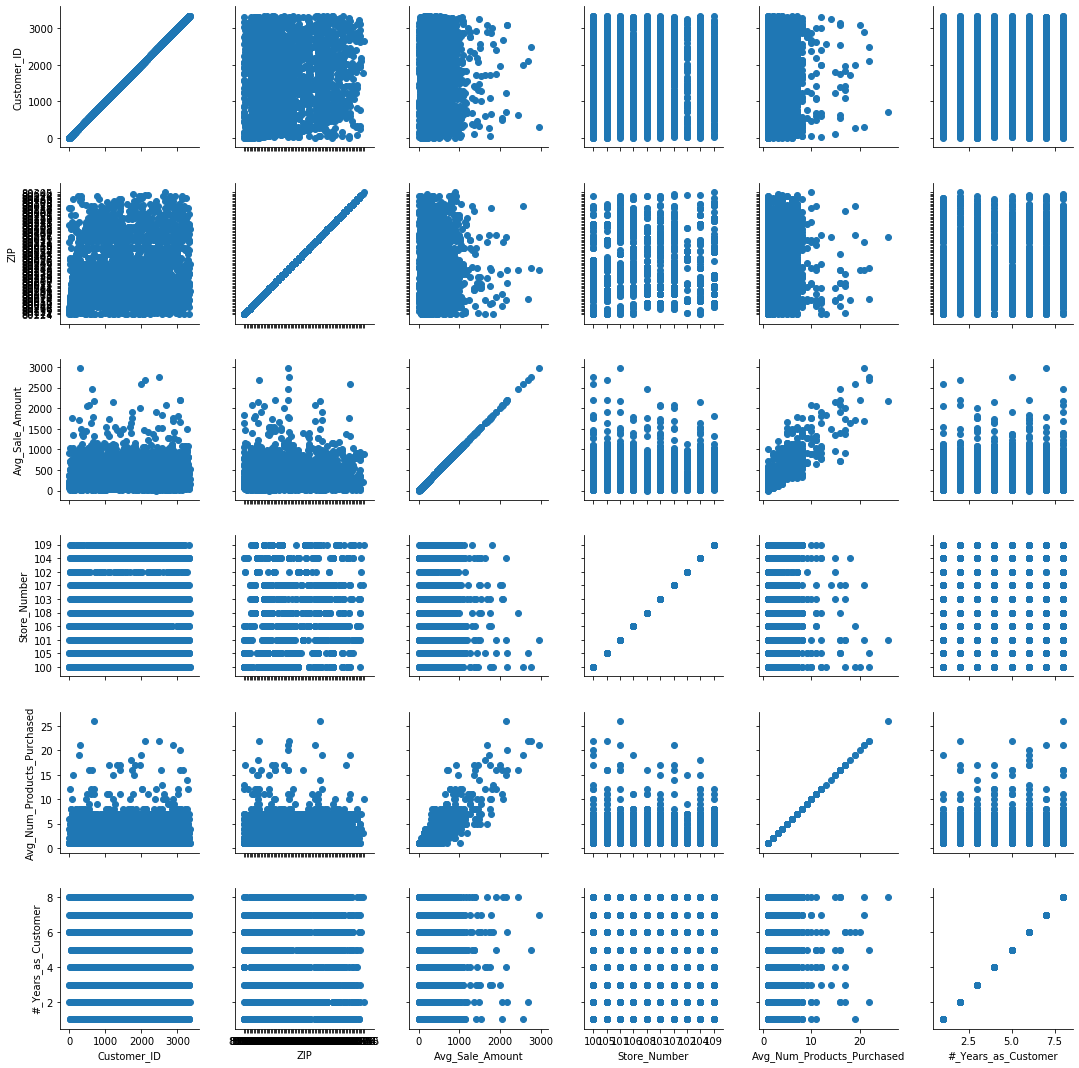

In [25]:
g = sns.PairGrid(cust_df)
g.map(plt.scatter);

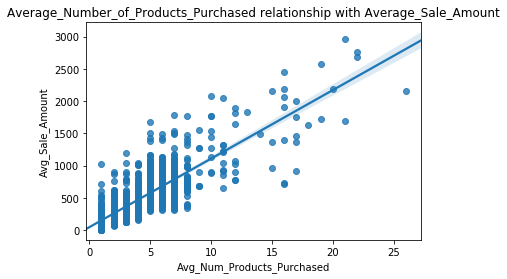

In [20]:
sns.regplot(x='Avg_Num_Products_Purchased',y='Avg_Sale_Amount', data=cust_df)
plt.title('Average_Number_of_Products_Purchased relationship with Average_Sale_Amount')
plt.show()

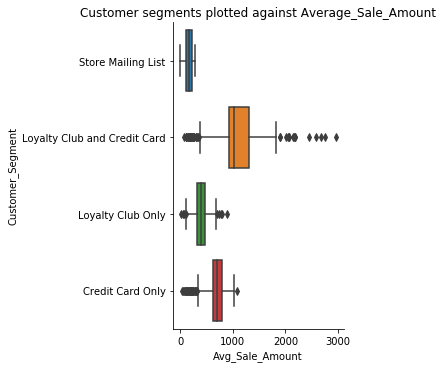

In [21]:
sns.catplot(y='Customer_Segment',x='Avg_Sale_Amount', orient='h', kind="box", data=cust_df)
plt.title('Customer segments plotted against Average_Sale_Amount')
plt.show()

In [2]:
# Get the dependent variable
y = cust_df['Avg_Sale_Amount']
# Get the predictor variables 
choice = ['Customer_Segment','Avg_Num_Products_Purchased']
# Dummify variables
X = pd.get_dummies(cust_df[choice], columns=['Customer_Segment'], drop_first=True)
# Fit the linear model
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        Avg_Sale_Amount   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              5832.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                        0.00
Time:                        23:45:02   Log-Likelihood:                         -15415.
No. Observations:                2375   AIC:                                  3.084e+04
Df Residuals:                    2371   BIC:                                  3.086e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------

In [3]:
m_variables = ['Customer_Segment', 'Avg_Num_Products_Purchased']
probs = mail_df[['Score_No','Score_Yes']]
X_mail = mail_df[m_variables]
# Get dummy variables
X_mail = pd.get_dummies(X_mail, columns=['Customer_Segment'], drop_first=True)
# Build final dataframe 'mail_dff'
mail_dff = mail_df[['Customer_Segment','Avg_Num_Products_Purchased','Score_No','Score_Yes']].copy()
mail_dff['Predicted_Avg_Sale_Amount'] = res.predict(X_mail)
mail_dff['Predicted_Avg_Sale_Amount'] = mail_dff['Predicted_Avg_Sale_Amount'] * mail_dff['Score_Yes']
mail_dff.head()

,Customer_Segment,Avg_Num_Products_Purchased,Score_No,Score_Yes,Predicted_Avg_Sale_Amount
0,Loyalty Club Only,3,0.694964,0.305036,101.666852
1,Loyalty Club and Credit Card,6,0.527275,0.472725,445.002012
2,Loyalty Club Only,7,0.421118,0.578882,429.672543
3,Loyalty Club Only,2,0.694862,0.305138,70.504258
4,Loyalty Club Only,4,0.612294,0.387706,168.858510


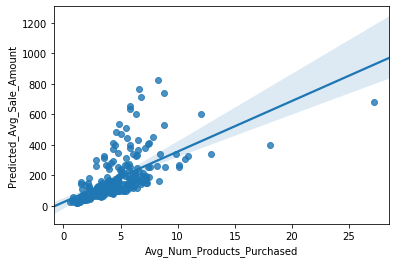

In [22]:
sns.regplot(x='Avg_Num_Products_Purchased',y='Predicted_Avg_Sale_Amount', x_jitter=0.5, data=mail_dff)
plt.show()

## Estimating Profits

In [5]:
gross_margin = 0.5 # average gross margin
cost = 6.50 # Cost of printing and sending catalog
mail_dff['Expected_Profit'] = (mail_dff['Predicted_Avg_Sale_Amount'] * gross_margin) - cost
expected_profit = round(mail_dff['Expected_Profit'].sum(),2)
print(f"From the model, we can expect a total profit of: ${expected_profit}")

From the model, we can expect a total profit of: $20852.09
